In [14]:
import gzip
import os
import shutil

import requests


def download_and_extract_dataset(url, save_path, folder_path):
    """Download and extract dataset if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        response = requests.get(url)
        with open(save_path, "wb") as file:
            file.write(response.content)

        decompressed_file_name = os.path.splitext(os.path.basename(save_path))[0]
        decompressed_file_path = os.path.join(folder_path, decompressed_file_name)

        with gzip.open(save_path, "rb") as f_in:
            with open(decompressed_file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f"{decompressed_file_name} downloaded and extracted.")
    else:
        print(f"{os.path.basename(save_path)} already exists.")


file_info = [
    (
        "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
    ),
]

folder_name = "tmp/mnist"
folder_path = os.path.join(os.getcwd(), folder_name)

os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

# Download and extract each file
for url, file_name in file_info:
    path_to_save = os.path.join(folder_path, file_name)
    download_and_extract_dataset(url, path_to_save, folder_path)

# %%
import numpy as np


def read_idx3_ubyte_image_file(filename):
    """Read IDX3-ubyte formatted image data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_images = int.from_bytes(f.read(4), byteorder="big")
        num_rows = int.from_bytes(f.read(4), byteorder="big")
        num_cols = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2051:
            raise ValueError(f"Invalid magic number: {magic_num}")

        images = np.zeros((num_images, num_rows, num_cols), dtype=np.uint8)

        for i in range(num_images):
            for r in range(num_rows):
                for c in range(num_cols):
                    pixel = int.from_bytes(f.read(1), byteorder="big")
                    images[i, r, c] = pixel

    return images


def read_idx1_ubyte_label_file(filename):
    """Read IDX1-ubyte formatted label data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_labels = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2049:
            raise ValueError(f"Invalid magic number: {magic_num}")

        labels = np.zeros(num_labels, dtype=np.uint8)

        for i in range(num_labels):
            labels[i] = int.from_bytes(f.read(1), byteorder="big")

    return labels


# Example usage
folder_path = os.path.join(
    os.getcwd(), folder_name
)  # Adjust this path to where you stored the files

train_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "train-images-idx3-ubyte")
)
train_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "train-labels-idx1-ubyte")
)
test_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "t10k-images-idx3-ubyte")
)
test_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "t10k-labels-idx1-ubyte")
)

print(
    f"Shape of train_images: {train_images.shape}"
)  # Should output "Shape of train_images: (60000, 28, 28)"
print(
    f"Shape of train_labels: {train_labels.shape}"
)  # Should output "Shape of train_labels: (60000,)"
print(
    f"Shape of test_images: {test_images.shape}"
)  # Should output "Shape of test_images: (10000, 28, 28)"
print(
    f"Shape of test_labels: {test_labels.shape}"
)  # Should output "Shape of test_labels: (10000,)"

# %%
# Reshape the datasets from 3D to 2D
train_images_2d = train_images.reshape(
    train_images.shape[0], -1
)  # -1 infers the size from the remaining dimensions
test_images_2d = test_images.reshape(test_images.shape[0], -1)

train-images-idx3-ubyte.gz already exists.
train-labels-idx1-ubyte.gz already exists.
t10k-images-idx3-ubyte.gz already exists.
t10k-labels-idx1-ubyte.gz already exists.
Shape of train_images: (60000, 28, 28)
Shape of train_labels: (60000,)
Shape of test_images: (10000, 28, 28)
Shape of test_labels: (10000,)


In [15]:
def average_intensity(image):
    return np.mean(image)

In [21]:
def aspect_ratio(image, threshold=128):
    # Threshold the image to create a binary representation
    bin_image = image > threshold
    # Find the bounding box
    row_indices, col_indices = np.nonzero(bin_image)
    max_row, min_row = np.max(row_indices), np.min(row_indices)
    max_col, min_col = np.max(col_indices), np.min(col_indices)

    # Calculate the aspect ratio of the bounding box
    width = max_col - min_col + 1
    height = max_row - min_row + 1

    if height == 0:  # To avoid division by zero
        return 1.0

    return width / height

In [73]:
from scipy.ndimage import label


def num_regions_below_threshold(image, threshold=128):
    # Threshold the image so that pixels below the threshold are set to 1
    # and those above the threshold are set to 0.
    bin_image = image < threshold

    # Use connected components labeling
    labeled_array, num_features = label(bin_image)

    # Return the number of unique regions
    # (subtracting 1 as one of the labels will be the background)
    return num_features

In [17]:
from scipy.optimize import curve_fit


def linear_func(x, a, b):
    return a * x + b


def avg_dist_to_fitted_line(image, threshold=128):
    # Threshold the image
    bin_image = (image > threshold).astype(int)

    # Identify connected components
    labeled_array, num_features = label(bin_image)

    # Find the largest connected component
    largest_component = None
    max_count = 0
    for i in range(1, num_features + 1):
        component = np.where(labeled_array == i)
        count = len(component[0])
        if count > max_count:
            max_count = count
            largest_component = component

    if largest_component is None:
        return 0.0

    x, y = largest_component
    if len(x) <= 1:  # Can't fit a line to a single point or empty set
        return 0.0

    # Fit a line to the largest component
    popt, _ = curve_fit(linear_func, x, y)

    # Calculate the average distance from each point to the line
    distances = np.abs(y - linear_func(x, *popt))
    avg_distance = np.mean(distances)
    return avg_distance

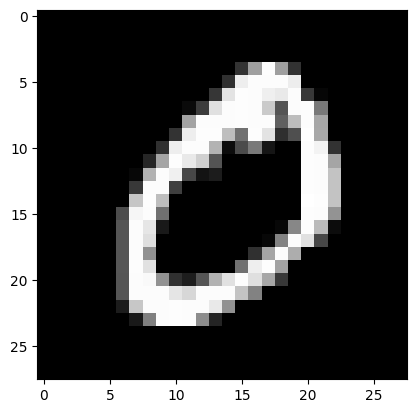

Image shape (28, 28)
Label 0
Average intensity 39.661989795918366
Aspect ratio 0.8
Number of white regions 2
Average distance to fitted line 3.7899477038171323


In [75]:
image_id = 1

image = train_images_2d[image_id].reshape(28, 28)

# plot train_images_2d[0]
import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.show()

print("Image shape", image.shape)

print("Label", train_labels[image_id])
print("Average intensity", average_intensity(image))
print("Aspect ratio", aspect_ratio(image))
print("Number of white regions", num_regions_below_threshold(image, threshold=120))
print(
    "Average distance to fitted line",
    avg_dist_to_fitted_line(image),
)

In [80]:
# compute datasets
num_train = len(train_images)
num_test = len(test_images)

average_intensity_train = np.zeros(num_train)
average_intensity_test = np.zeros(num_test)

aspect_ratio_train = np.zeros(num_train)
aspect_ratio_test = np.zeros(num_test)

num_white_regions_train = np.zeros(num_train)
num_white_regions_test = np.zeros(num_test)

avg_dist_to_fitted_line_train = np.zeros(num_train)
avg_dist_to_fitted_line_test = np.zeros(num_test)

for i in range(num_train):
    average_intensity_train[i] = average_intensity(train_images_2d[i].reshape(28, 28))
    aspect_ratio_train[i] = aspect_ratio(train_images_2d[i].reshape(28, 28))
    num_white_regions_train[i] = num_regions_below_threshold(
        train_images_2d[i].reshape(28, 28)
    )
    avg_dist_to_fitted_line_train[i] = avg_dist_to_fitted_line(
        train_images_2d[i].reshape(28, 28)
    )

for i in range(num_test):
    average_intensity_test[i] = average_intensity(test_images_2d[i].reshape(28, 28))
    aspect_ratio_test[i] = aspect_ratio(test_images_2d[i].reshape(28, 28))
    num_white_regions_test[i] = num_regions_below_threshold(
        test_images_2d[i].reshape(28, 28)
    )
    avg_dist_to_fitted_line_test[i] = avg_dist_to_fitted_line(
        test_images_2d[i].reshape(28, 28)
    )

/Users/kp/miniconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [81]:
# combine average intentisty and aspect ratio into a single feature vector
train_features = np.zeros((num_train, 2))

train_features[:, 0] = average_intensity_train
train_features[:, 1] = aspect_ratio_train

test_features = np.zeros((num_test, 2))

test_features[:, 0] = average_intensity_test
test_features[:, 1] = aspect_ratio_test

In [82]:
from sklearn.tree import DecisionTreeClassifier

# Create and train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf.fit(train_features, train_labels)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [83]:
import numpy as np

# Compute the accuracy of the Leo program and the Python program on the test set
num_test_samples = len(test_features)
python_predictions = clf.predict(test_features)
python_accuracy = np.sum(python_predictions == test_labels) / num_test_samples
print(f"Python accuracy: {100*python_accuracy} %")

Python accuracy: 29.160000000000004 %


In [54]:
print("classifier depth", clf.get_depth())

classifier depth 10


## Try out an SVM

In [56]:
# train an SVM with RBF kernel

from sklearn.svm import SVC

# Create and train an SVM classifier with an RBF kernel
clf = SVC(kernel="rbf", random_state=0)
clf.fit(train_features, train_labels)

SVC(random_state=0)

In [57]:
python_predictions = clf.predict(test_features)
python_accuracy = np.sum(python_predictions == test_labels) / num_test_samples
print(f"Python accuracy: {100*python_accuracy} %")

Python accuracy: 26.36 %


## Add more features to the dataset

In [84]:
train_features = np.zeros((num_train, 4))

train_features[:, 0] = average_intensity_train
train_features[:, 1] = aspect_ratio_train
train_features[:, 2] = avg_dist_to_fitted_line_train
train_features[:, 3] = num_white_regions_train

test_features = np.zeros((num_test, 4))

test_features[:, 0] = average_intensity_test
test_features[:, 1] = aspect_ratio_test
test_features[:, 2] = avg_dist_to_fitted_line_test
test_features[:, 3] = num_white_regions_test

In [85]:
from sklearn.tree import DecisionTreeClassifier

# Create and train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf.fit(train_features, train_labels)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [86]:
import numpy as np

# Compute the accuracy of the Leo program and the Python program on the test set
num_test_samples = len(test_features)
python_predictions = clf.predict(test_features)
python_accuracy = np.sum(python_predictions == test_labels) / num_test_samples
print(f"Python accuracy: {100*python_accuracy} %")

Python accuracy: 50.8 %


In [79]:
# Create and train an SVM classifier with an RBF kernel
clf = SVC(kernel="rbf", random_state=0)
clf.fit(train_features, train_labels)

SVC(random_state=0)

In [63]:
python_predictions = clf.predict(test_features)
python_accuracy = np.sum(python_predictions == test_labels) / num_test_samples
print(f"Python accuracy: {100*python_accuracy} %")

Python accuracy: 36.1 %
